## CNN Feature Map Visualization

### Notebook & Packages

In [1]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-21 21:45:07.797804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734817507.815726 1017027 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734817507.821185 1017027 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 21:45:07.838737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
No GPUs found. Running on CPU.

Number of available CPU cores: 16

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.18.0
Built with CUDA: True
Num GPUs Available: 0

Keras version: 3.6.0

End checks and initialization.


W0000 00:00:1734817509.645476 1017027 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout # General Layers
from keras.layers import RandomRotation, RandomFlip
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.initializers import glorot_uniform
from keras.utils import plot_model
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff
from tifffile import imread
from matplotlib import cm
from matplotlib.colors import Normalize
# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

from sklearn.manifold import TSNE

#### Import Data

In [3]:
images_dir = '/home/jupyter-luvogt/Final_Project_LR/IMC_images' 
metadata_dir = '/home/jupyter-luvogt/Final_Project_LR/metadata.csv'
# --- Load CSV and filter dataset ---
csv_file = metadata_dir
image_folder = images_dir
# Load the CSV
df = pd.read_csv(csv_file)
# Filter rows with NA in PDL1_score and convert to binary
df = df.dropna(subset=["PDL1_score"])
df["PDL1_score"] = df["PDL1_score"].astype(int)
# --- Train-Test-Validation Split ---
train_df, val_and_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["PDL1_score"])
test_df, val_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42, stratify=val_and_test_df["PDL1_score"])
# Function to load a single image
def load_image(image_path):
    image = imread(image_path)  # Load all 46 channels
    return image.astype(np.float32)
# Initialize variables to accumulate sum and sum of squares
nr_images = 0
sum_images = np.zeros((46, 224, 224))
sum_squared_images = np.zeros((46, 224, 224))
# Accumulate the sum and sum of squares for the training dataset
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
    image = load_image(image_path)
    nr_images += 1
    sum_images += image
    sum_squared_images += image ** 2
# Compute mean and standard deviation
mean = sum_images / nr_images
std = np.sqrt(sum_squared_images / nr_images - mean ** 2)
# -- Dataset Loading Function ---
def load_dataset(dataframe, image_folder, normalize = True): # augment = False
    images = []
    labels = []
    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
        image = load_image(image_path)
        if normalize:
            image = (image - mean) / std
        # Convert to channels-last format (224, 224, 46)
        image = np.transpose(image, (1, 2, 0))
        images.append(image)
        labels.append(row["PDL1_score"])

    return np.array(images), np.array(labels)
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


### Create Datasets

In [ ]:
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

### Drop Channels

In [5]:
def drop_channels(image, channels_of_interest, channel_names):
        channel_names_new = [i for i in channel_names if i not in channels_of_interest]
        mask = np.zeros(image.shape[2], dtype=bool) # Error: np.zeros(image.shape[0], dtype=bool) and NOT np.zeros(image.shape[2], dtype=bool) (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        for i in channels_of_interest:
            mask[channel_names.index(i)] = True
        image = image[:, :, mask] # Error: image[mask, :, :] and not image[:, :, mask] ! (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        return image

In [6]:
channel_names_new = ["Gd160", "Eu153", "Gd155"]

panel_dir = '/home/jupyter-luvogt/Final_Project_LR/panel.csv' 
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

In [7]:
X_train = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_train]
X_val = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_val]
X_test = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_test]

In [6]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)


## ResNet18: Dropout + ReduceLROnPlateau + 3 Biological Channels

### Extract last layer before classification

In [9]:
# Load Best Model
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_biological_channels_trained.keras')

### Get Prediction for full model 

In [10]:
y_pred = model_ResNet18.predict(X_test)

I0000 00:00:1734555299.888211  865184 service.cc:146] XLA service 0x7f4a6411c2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734555299.888263  865184 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-18 20:54:59.914881: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 20:55:00.054123: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

I0000 00:00:1734555301.937187  865184 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step


### Get Layer Names

In [11]:
layer_names = [layer.name for layer in model_ResNet18.layers]

We want dense2 layer to be extracted

### Get Layer Output

In [12]:
layer_outputs = [layer.output for layer in model_ResNet18.layers]

In [13]:
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)

In [14]:
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [15]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)

In [16]:
y_pred_feature_map = np.zeros(shape = (197, 512))

In [17]:
y_pred_feature_map.shape

(197, 512)

In [18]:
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

In [19]:
y_pred_feature_map[0].shape

(512,)

In [20]:
feature_map_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 115, 115,  │      9,472 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 115, 115,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 115, 115,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 115, 115,  │          0 │ dropout_20[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 58, 58,    │          0 │ activation_34[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 58, 58,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 58, 58,    │          0 │ dropout_21[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 58, 58,    │     36,928 │ activation_35[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 58, 58,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 58, 58,    │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 58, 58,    │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        256 │ conv2d_43[0][0] 

 Total params: 15,382,144 (58.68 MB)

 Trainable params: 15,374,336 (58.65 MB)

 Non-trainable params: 7,808 (30.50 KB)

### t-SNE on output data with 3 channels

In [22]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map)

In [23]:
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [24]:
# y_pred = (y_pred > 0.5).astype(int)

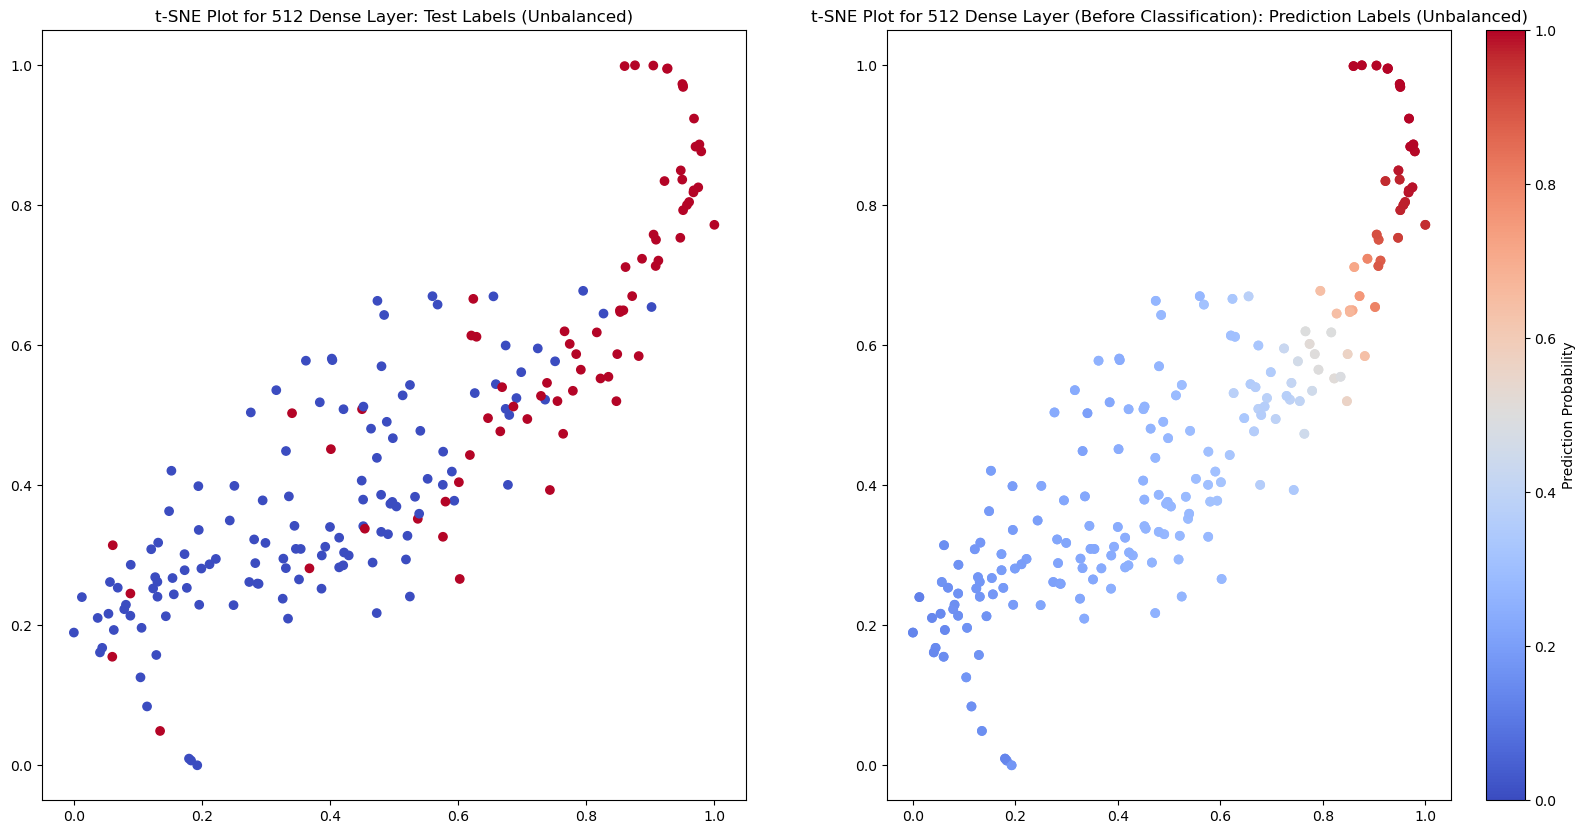

In [26]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_test, cmap=cmap, label = colors_per_class, norm = norm)
sc = ax2.scatter(tx, ty, c=y_pred, cmap=cmap, norm=norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer: Test Labels (Unbalanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (Unbalanced)")
 
# finally, show the plot
plt.show()

## t-SNE for unbalanced dataset and biological channels

In [27]:
# X_train: Define Undersampling balancing method
import imblearn
from imblearn.under_sampling import RandomUnderSampler
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_test_flat = X_test.reshape(X_test.shape[0], -1) # Reshape images for balancer
X_test_resampled, y_test_resampled = balancer.fit_resample(X_test_flat, y_test) # resample (Undersampling)
X_test_resampled = X_test_resampled.reshape(-1, *X_test.shape[1:]) # Reshape the image

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### Model balanced dataset

In [28]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.keras')

### Get Prediction

In [29]:
y_pred_resampled = model_ResNet18.predict(X_test_resampled)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step


### Get Layer Names and Layer Outputs

In [30]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model

In [ ]:
X_test_resampled.shape

In [31]:
feature_map_model_resampled = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map_resampled = np.zeros(shape = (144, 512)) # CHANGE HERE

### Predict with Feature Map Model

In [32]:
for i,x in enumerate(X_test_resampled): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model_resampled.predict(x_expanded, verbose = 0)
    y_pred_feature_map_resampled[i] = pred[0]
    gc.collect()

### t-SNE

In [34]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map_resampled)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

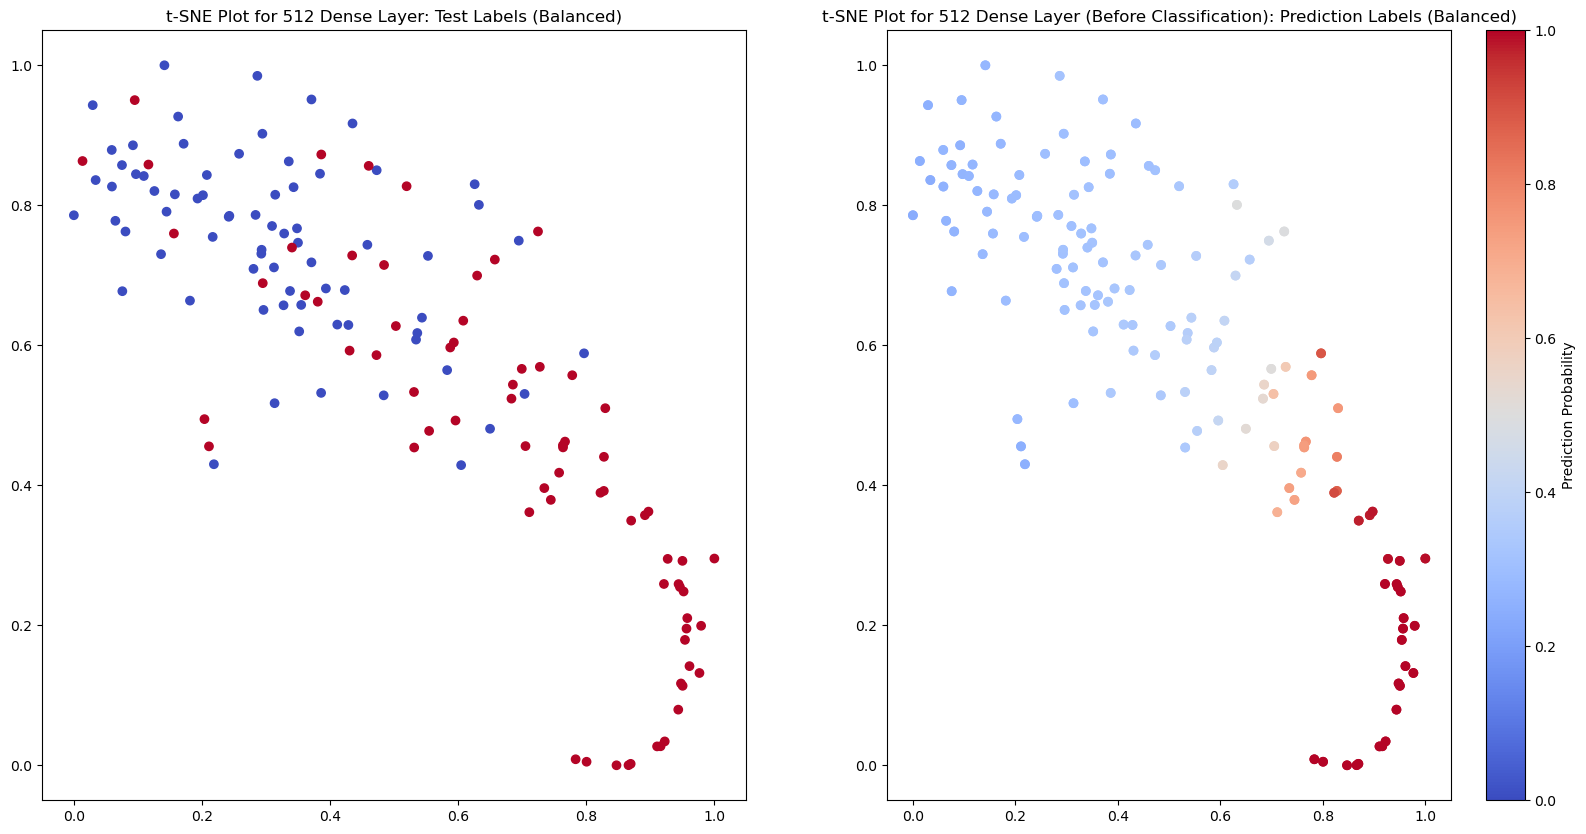

In [41]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred_resampled, cmap=cmap, label = colors_per_class, norm = norm)
sc = ax2.scatter(tx, ty, c=y_pred_resampled, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_test_resampled, cmap=cmap, label = colors_per_class, norm = norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer: Test Labels (Balanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (Balanced)")
 
# finally, show the plot
plt.show()

## t-SNE: with 46 channels

### Model 46 channels

In [42]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')

In [7]:
### Create Dataset new
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

### Get Prediction

In [44]:
y_pred = model_ResNet18.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step


### Get Layer Names and Layers Output

In [45]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [46]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map = np.zeros(shape = (197, 512))
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

### t-SNE for 46 channels

In [47]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
# y_pred = (y_pred > 0.5).astype(int)

/tmp/ipykernel_865089/356318823.py:10: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1000 with 3 Axes> than <Figure size 2000x1000 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax2)


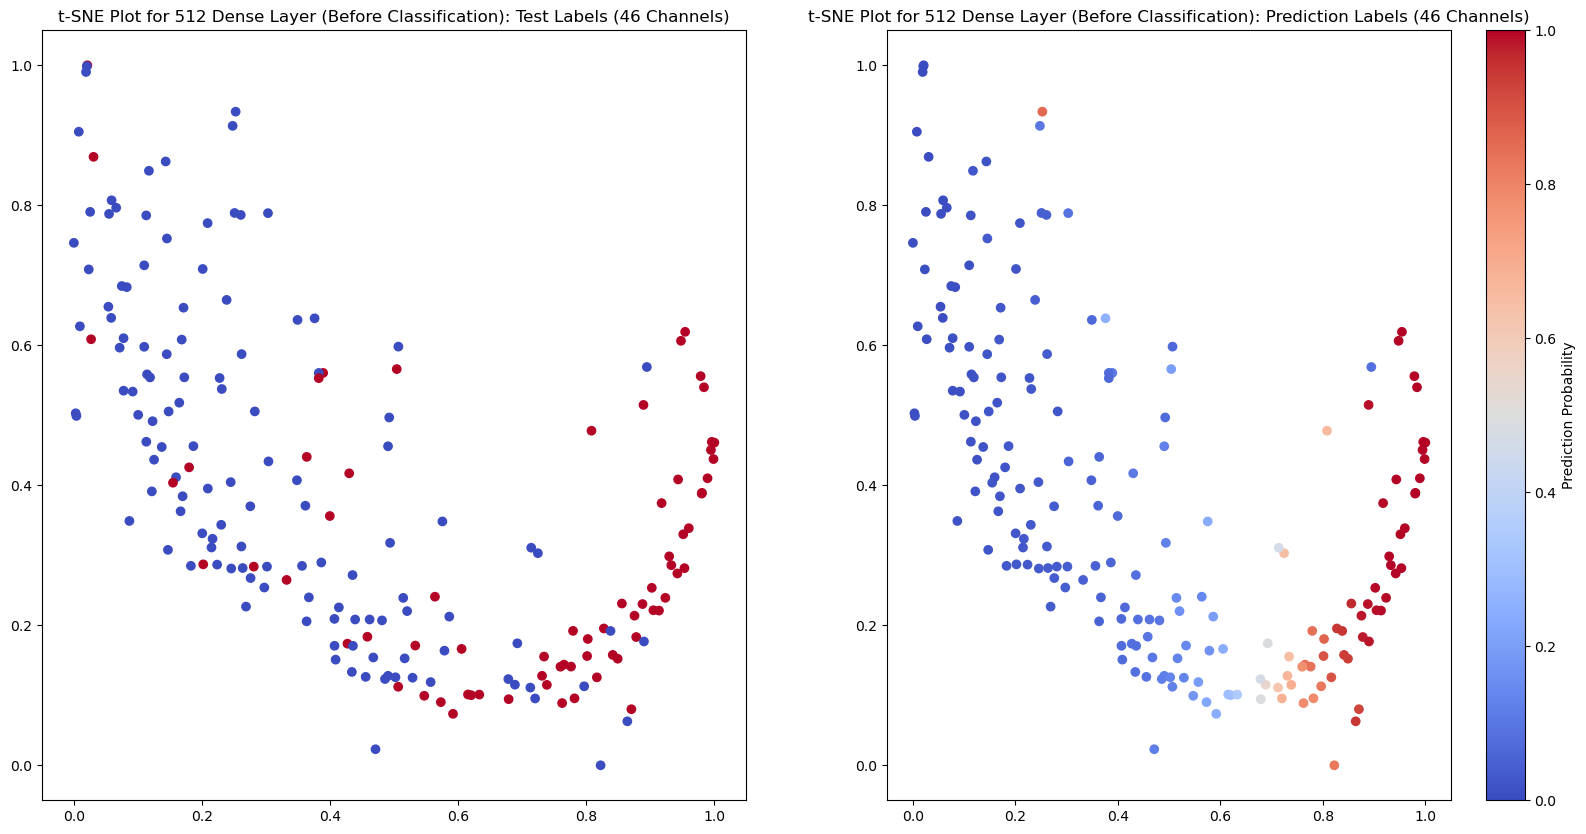

In [48]:
# initialize a matplotlib plot
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_test, cmap=cmap, label = colors_per_class, norm = norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Test Labels (46 Channels)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (46 Channels)")
 
# finally, show the plot
plt.show()

## t-SNE: 46 channels + balanced

In [5]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_trained.keras')

2024-12-18 19:16:49.789435: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 13.00GiB (13958643712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789588: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 11.70GiB (12562779136 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789694: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 10.53GiB (11306501120 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789798: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 9.48GiB (10175850496 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.789901: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 8.53GiB (9158264832 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-12-18 19:16:49.790

In [6]:
### Create Dataset new
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

In [7]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# X_train: Define Undersampling balancing method
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_train_flat = X_train.reshape(X_train.shape[0], -1) # Reshape images for balancer
X_train_resampled, y_train_resampled = balancer.fit_resample(X_train_flat, y_train) # resample (Undersampling)
X_train_resampled = X_train_resampled.reshape(-1, *X_train.shape[1:]) # Reshape the image

# X_val: Define Undersampling balancing method
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_val_flat = X_val.reshape(X_val.shape[0], -1) # Reshape images for balancer
X_val_resampled, y_val_resampled = balancer.fit_resample(X_val_flat, y_val) # resample (Undersampling)
X_val_resampled = X_val_resampled.reshape(-1, *X_val.shape[1:]) # Reshape the image

X_test_flat = X_test.reshape(X_test.shape[0], -1) # Reshape images for balancer
X_test_resampled, y_test_resampled = balancer.fit_resample(X_test_flat, y_test) # resample (Undersampling)
X_test_resampled = X_test_resampled.reshape(-1, *X_test.shape[1:]) # Reshape the image

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/bas

### Get Prediction

In [38]:
y_pred = model_ResNet18.predict(X_test)

2024-12-18 19:55:33.280821: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1818779648 exceeds 10% of free system memory.
2024-12-18 19:55:34.282306: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1818779648 exceeds 10% of free system memory.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


### Get Names and Outputs

In [44]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [10]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map = np.zeros(shape = (197, 512))
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

### t-SNE: 46 Channels + Balanced

In [45]:
tsne = TSNE(n_components=2).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
# y_pred = (y_pred > 0.5).astype(int)

/tmp/ipykernel_850776/3549757980.py:41: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1000 with 2 Axes> than <Figure size 2500x1000 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax2)


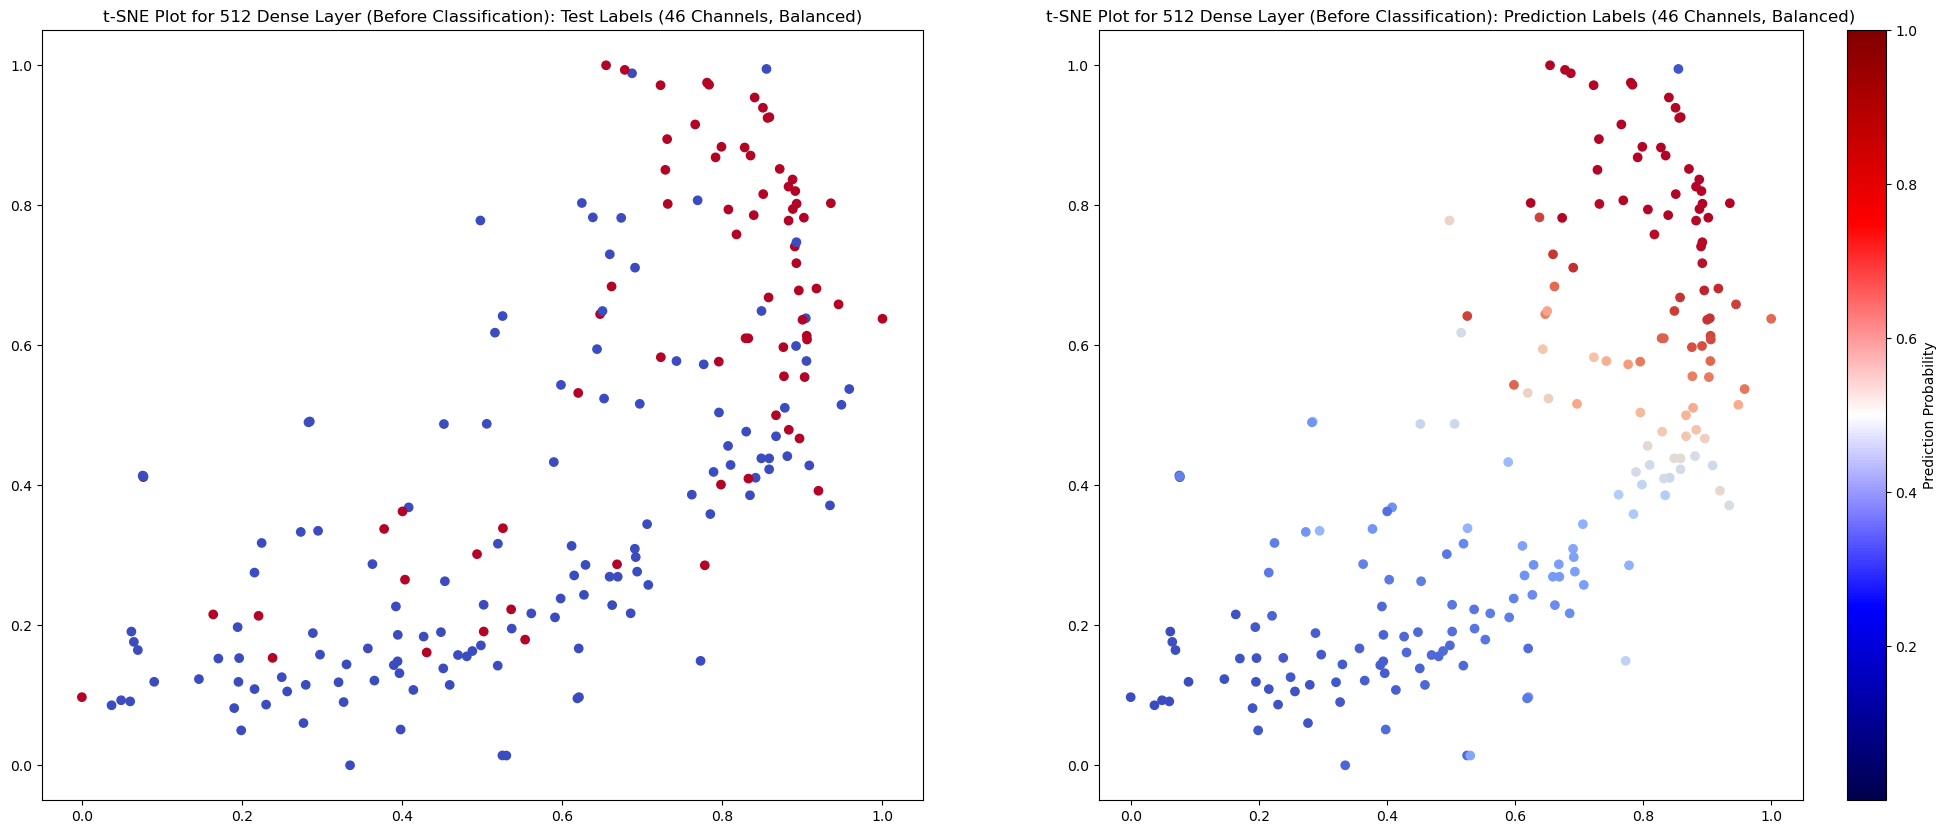

In [74]:
# initialize a matplotlib plot
from matplotlib import cm
from matplotlib.colors import Normalize
fig = plt.figure(figsize = [25, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_test, cmap=cmap, label = colors_per_class, norm = norm)
sc = ax2.scatter(tx, ty, c=y_pred, cmap=cmap, norm=norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Test Labels (46 Channels, Balanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer (Before Classification): Prediction Labels (46 Channels, Balanced)")
 
# finally, show the plot
plt.show()

## t-SNE: for training, validation and testing

### Get Model

In [4]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_trained.keras')

### Get Dataset

In [4]:
### Create Dataset new
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

In [5]:
X_total = np.concatenate((X_train, X_val, X_test), axis = 0)

In [10]:
flattened_pixels = X_total[:, :, :, 20].flatten()

In [15]:
x = np.linspace(-3,3,len(flattened_pixels))

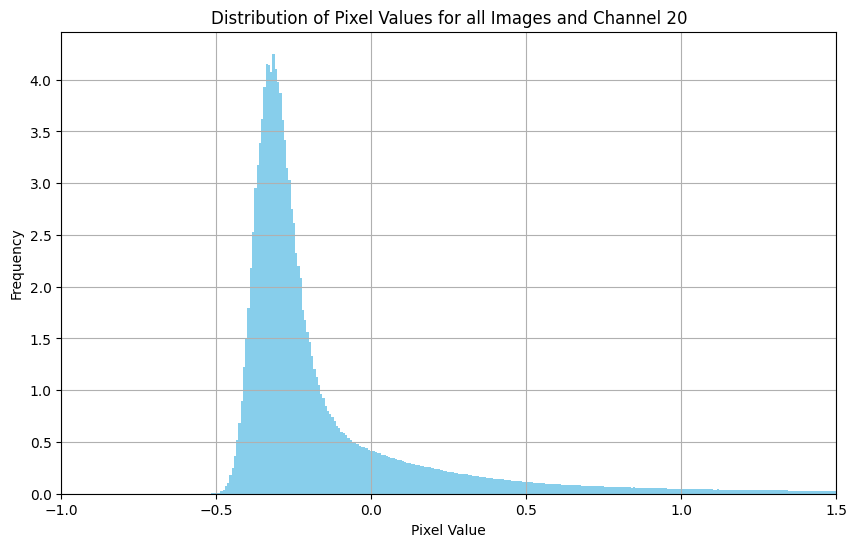

In [24]:
# Plot a histogram of the pixel values
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.hist(flattened_pixels, bins = 100000, density = True, color='skyblue', fill=True, linewidth=2)
plt.title(f"Distribution of Pixel Values for all Images and Channel 20")
plt.xlim(-1, 1.5)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [7]:
y_total = np.concatenate((y_train, y_val, y_test), axis = 0)

In [8]:
y_pred = model_ResNet18.predict(X_total)

2024-12-19 21:35:00.109678: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9084665856 exceeds 10% of free system memory.
2024-12-19 21:35:07.068104: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9084665856 exceeds 10% of free system memory.
I0000 00:00:1734644126.003404  964218 service.cc:146] XLA service 0x7f6b4d01da50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734644126.008706  964218 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-19 21:35:26.310119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 21:35:27.081094: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
2024-12-19 21:35:29.850536: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out

 1/31 ━━━━━━━━━━━━━━━━━━━━ 4:55 10s/step

I0000 00:00:1734644132.701275  964218 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step


### Get Layer and Outputs

In [9]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

### Feature Map Model 

In [10]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map = np.zeros(shape = (984, 512))
for i,x in enumerate(X_total): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

### t-SNE: Perplexity = 30

Try different Perplexities

In [ ]:
tsne = TSNE(n_components=2, random_state = 42, learning_rate = "auto", perplexity = 30).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

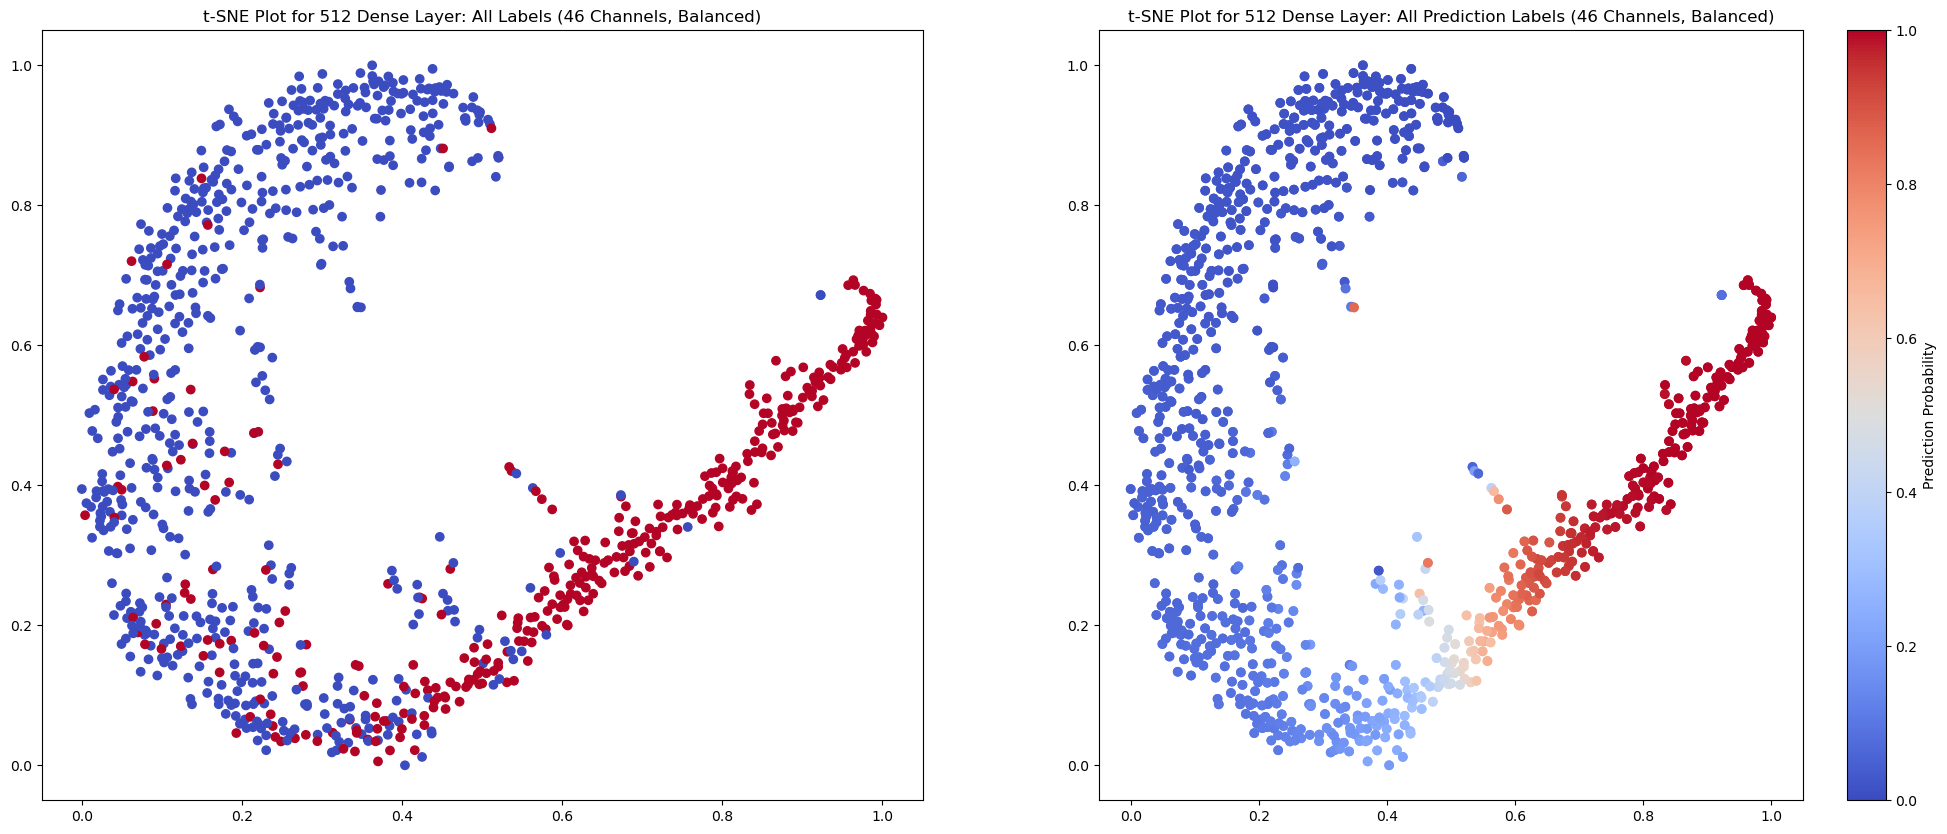

In [26]:
# initialize a matplotlib plot
from matplotlib import cm
from matplotlib.colors import Normalize
fig = plt.figure(figsize = [25, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_total, cmap=cmap, label = colors_per_class, norm = norm)
sc = ax2.scatter(tx, ty, c=y_pred, cmap=cmap, norm=norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer: All Labels (46 Channels, Balanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer: All Prediction Labels (46 Channels, Balanced)")
 
# finally, show the plot
plt.show()

### Perplexity == 50

In [24]:
tsne = TSNE(n_components=2, random_state = 42, learning_rate = "auto", perplexity = 50).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

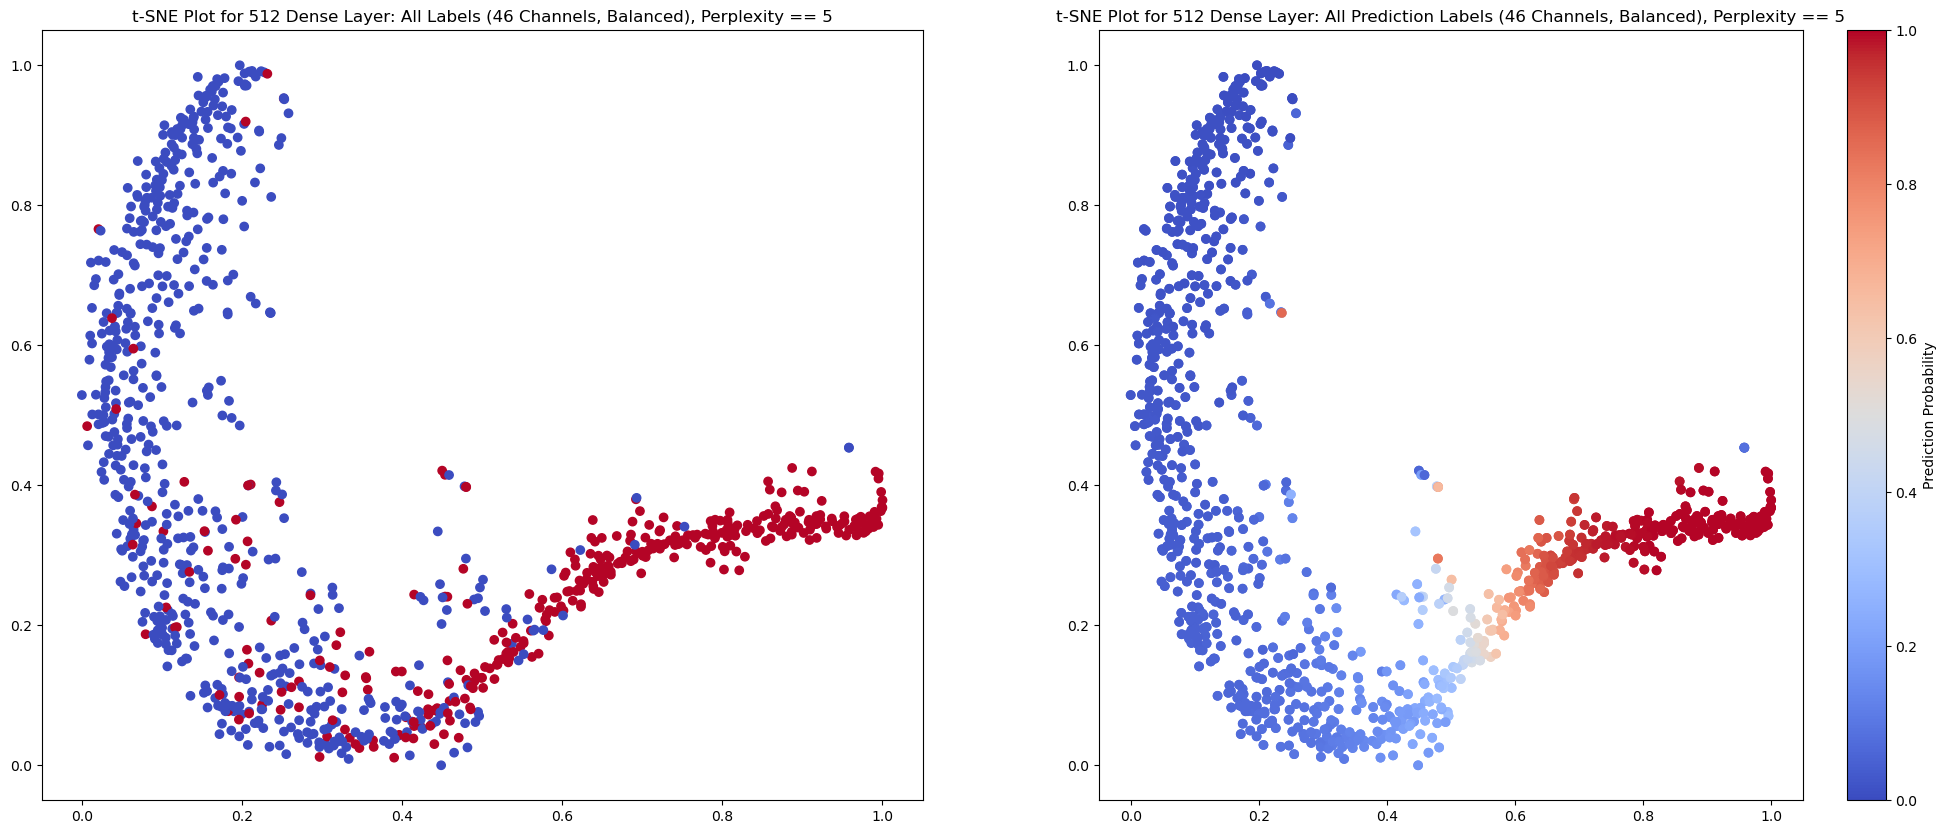

In [25]:
# initialize a matplotlib plot
from matplotlib import cm
from matplotlib.colors import Normalize
fig = plt.figure(figsize = [25, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_total, cmap=cmap, label = colors_per_class, norm = norm)
sc = ax2.scatter(tx, ty, c=y_pred, cmap=cmap, norm=norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer: All Labels (46 Channels, Balanced), Perplexity == 5")
ax2.set_title("t-SNE Plot for 512 Dense Layer: All Prediction Labels (46 Channels, Balanced), Perplexity == 5")
 
# finally, show the plot
plt.show()

### 3D t-SNE: Perplexity == 30

In [13]:
tsne = TSNE(n_components=3, random_state = 42, learning_rate = "auto", perplexity = 30).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
tz = tsne[:, 2]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tz = scale_to_01_range(tz)

In [23]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(11,11),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    plot_trisurf
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=45, elev=15)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()

In [21]:
points_color = y_pred
points = np.dstack([tx, ty, tz])[0]
title = "3D Embedding with t-SNE: All Labels (46 Channels, Balanced), Perplexity == 30"

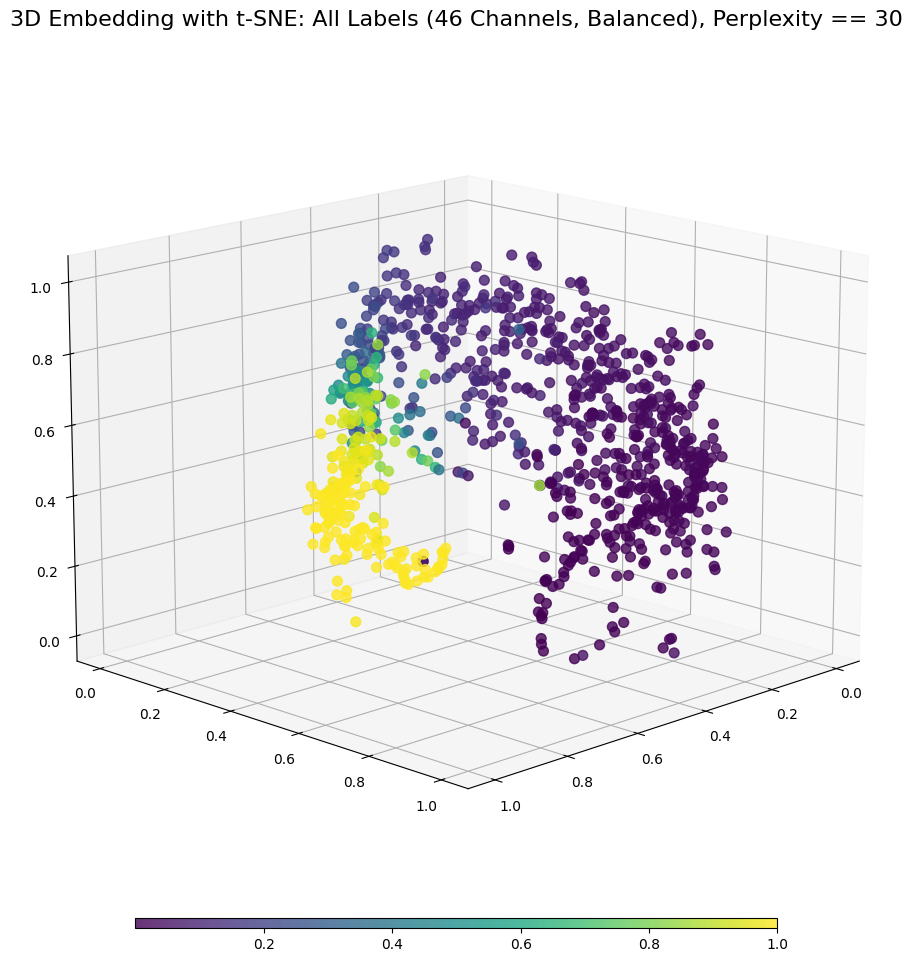

In [24]:
plot_3d(points, points_color, title)

### Visualizing it with interactive 3D

In [2]:
# !pip3 install ipympl # install library call ipympl to have interactive python plot in notebook
# !pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


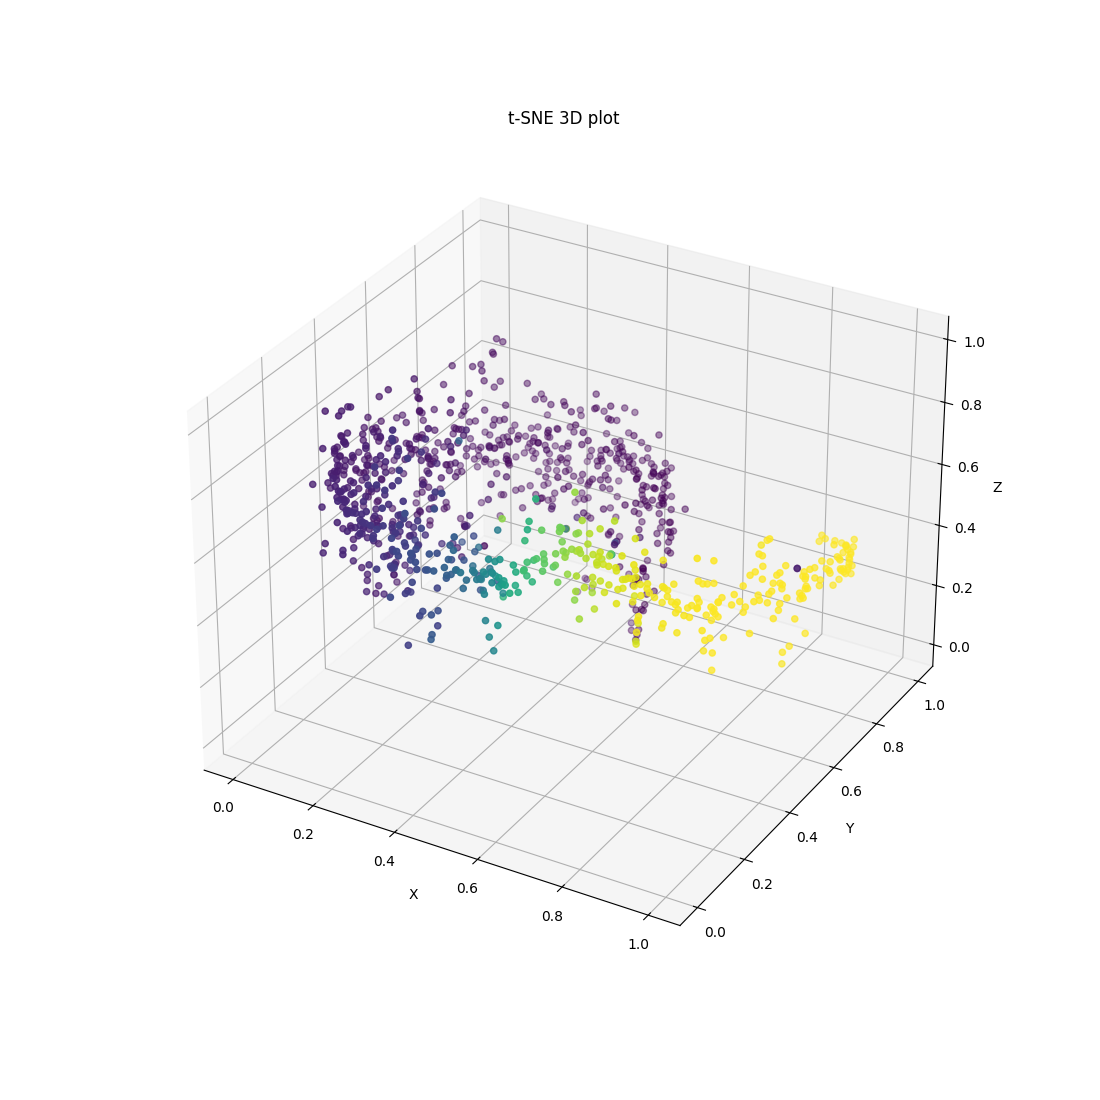

In [28]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import summary
import matplotlib.pyplot as plt

# Example: Let's assume y_pred_feature_map is your high-dimensional data
# Scale the data to [0, 1] range using MinMaxScaler
# Now set up TensorBoard logging for the 3D visualization
log_dir = 'logs/tb_test'
summary_writer = tf.summary.create_file_writer(log_dir)

# Create the scatter plot for 3D visualization
with summary_writer.as_default():
    for i in range(len(tx)):
        tf.summary.scalar('x', tx[i], step=i)
        tf.summary.scalar('y', ty[i], step=i)
        tf.summary.scalar('z', tz[i], step=i)

    # You can also create the 3D scatter plot with Matplotlib and save it
    fig = plt.figure(figsize=(11,11))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tx, ty, tz, c=y_pred, label='t-SNE points')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("t-SNE 3D plot")
    
    # Save the plot
    plt.savefig("3d_tsne_plot.png")

# Start TensorBoard to visualize the result
# In terminal, run: tensorboard --logdir=logs/tb_test

## ResNet 18 with GradCAM

In [3]:
model_ResNet18 = keras.saving.load_model('./models_ResNet/model_ResNet18_dropout_01_callbacks_sigmoid_biological_channels_GradCAM_trained.keras')

In [5]:
channel_names_new = ["In113", "Nd145", "Sm152", "Sm154", "Gd155", "Gd156", "Gd158", "Gd160", "Dy161", "Dy162", "Dy164", "Er166", "Er167", "Er170", "Yb171", "Yb173", "Yb176"]
panel_dir = '/home/jupyter-luvogt/Final_Project_LR/panel.csv' 
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

In [8]:
X_train = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_train]
X_val = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_val]
X_test = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_test]
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [9]:
y_pred = model_ResNet18.predict(X_test)

I0000 00:00:1734723763.211762 1004275 service.cc:146] XLA service 0x7f823401c360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734723763.211795 1004275 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-20 19:42:43.236470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-20 19:42:43.369017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

I0000 00:00:1734723765.637965 1004275 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step


In [10]:
layer_names = [layer.name for layer in model_ResNet18.layers]
layer_outputs = [layer.output for layer in model_ResNet18.layers]
second_last_layer_output = layer_outputs[:-1] # Get all the layers except the last one (disgard the classification layer)
second_last_layer_output.reverse() # IMPORTANT: need to reverse layers apparently, otherwise it predicts the data with the model backwards

In [12]:
feature_map_model = Model(inputs=model_ResNet18.input, outputs=second_last_layer_output)
y_pred_feature_map = np.zeros(shape = (197, 512))
for i,x in enumerate(X_test): 
    x_expanded = np.expand_dims(x, axis=0) 
    pred = feature_map_model.predict(x_expanded, verbose = 0)
    y_pred_feature_map[i] = pred[0]
    gc.collect()

### t-SNE 

In [19]:
tsne = TSNE(n_components=2, perplexity = 30).fit_transform(y_pred_feature_map)
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

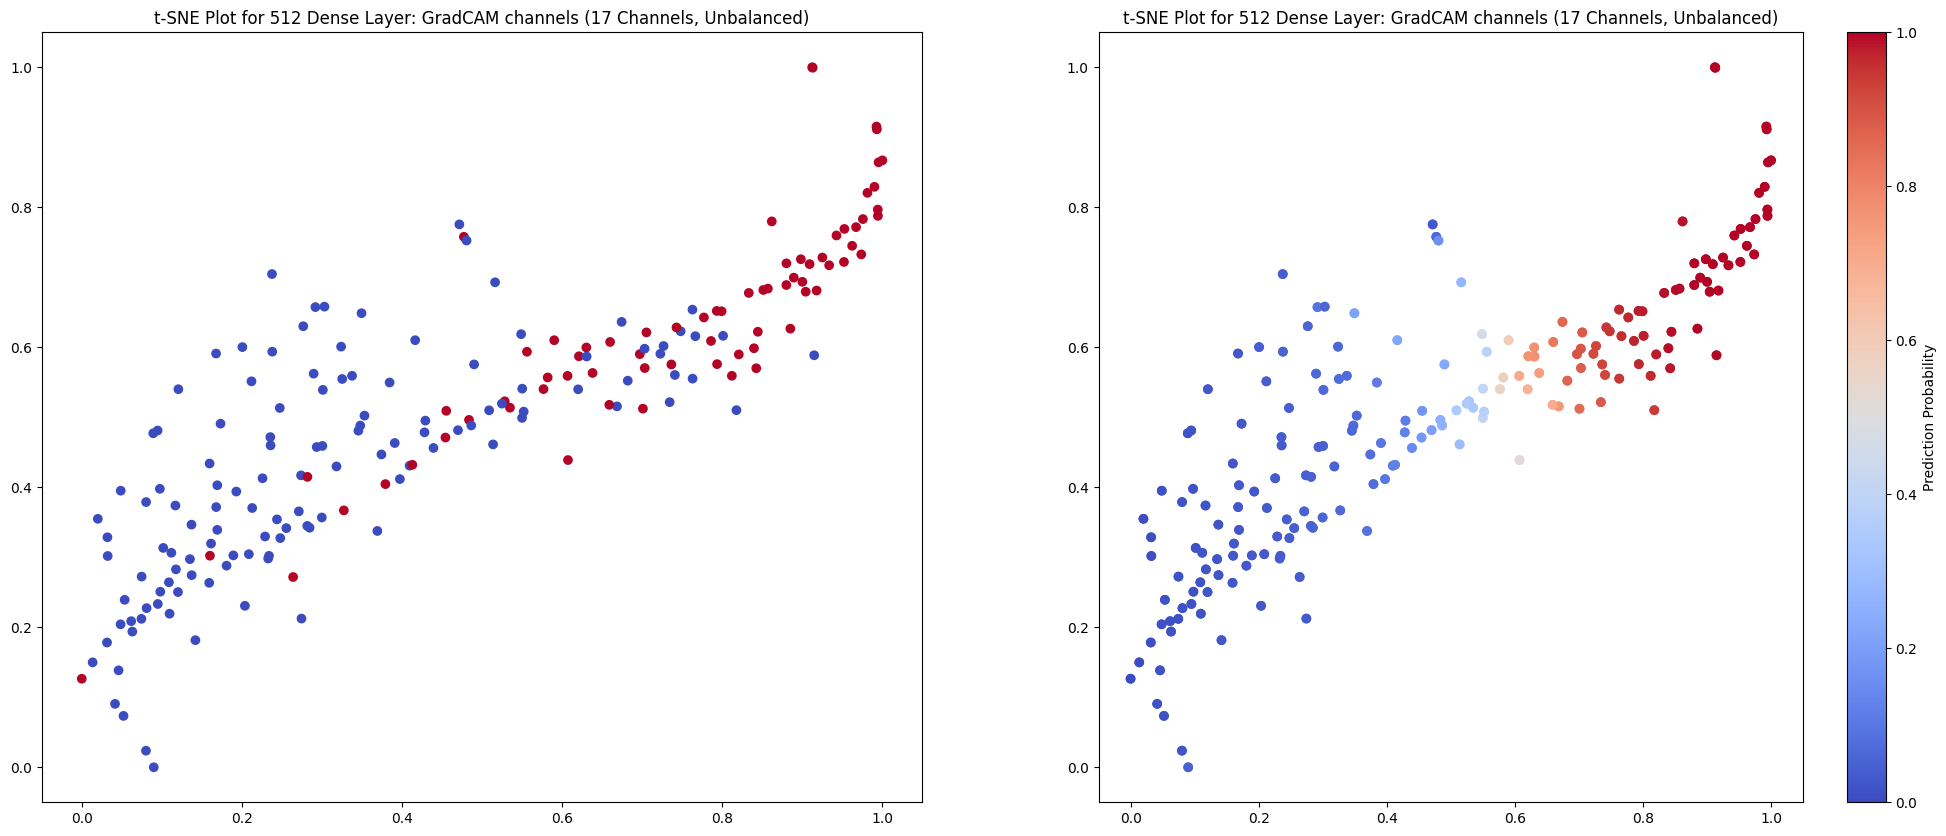

In [20]:
# initialize a matplotlib plot
from matplotlib import cm
from matplotlib.colors import Normalize
fig = plt.figure(figsize = [25, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
cmap = cm.coolwarm
norm = Normalize(vmin=0, vmax=1)
ax2.scatter(tx, ty, c=y_pred, cmap=cmap, label = colors_per_class, norm = norm)
ax1.scatter(tx, ty, c=y_test, cmap=cmap, label = colors_per_class, norm = norm)
sc = ax2.scatter(tx, ty, c=y_pred, cmap=cmap, norm=norm)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Prediction Probability')
ax1.set_title("t-SNE Plot for 512 Dense Layer: GradCAM channels (17 Channels, Unbalanced)")
ax2.set_title("t-SNE Plot for 512 Dense Layer: GradCAM channels (17 Channels, Unbalanced)")
 
# finally, show the plot
plt.show()